In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess

# %matplotlib notebook
%matplotlib inline

In [2]:
def barabasi_albert(n=10, m=4):
    G = nx.barabasi_albert_graph(n, m)
    G.graph["dissemination"] = "flooding"
    # compute power
    solving_rate = np.random.exponential(n, n).astype("d")
    for i in range(n):
        G.nodes[i]["compute"] = solving_rate[i] / np.sum(solving_rate)
    # edge distances
    distance = np.random.uniform(low=1, high=3, size=len(G.edges))
    for ((a, b), d) in zip(G.edges, distance):
        G.edges[a, b]["distance"] = d
        G.edges[a, b]["delay"] = f"uniform {d * 0.5} {d * 1.5}"
        G.edges[a, b]["spring_weight"] = 1 / d
    distances = dict(nx.shortest_path_length(G, weight="distance"))
    # closeness / farness metrics
    node_attr = dict()
    for i, d in distances.items():
        farness = sum(d.values()) / (n - 1)
        compute_farness = sum([G.nodes[j]["compute"] * d for j, d in d.items()])
        node_attr[i] = dict(
            farness=farness,
            closeness=1 / farness,
            compute_farness=compute_farness,
            compute_closeness=1 / compute_farness,
        )
    nx.set_node_attributes(G, node_attr)
    # done
    return G


def sim(G, protocol="nakamoto", activation_delay=1, activations=1000, seed=None):
    """
    Run simulator on given network G.
    """
    G = G.copy()
    type_of_node_key = type(list(G.nodes.keys())[0])
    G.graph["activation_delay"] = activation_delay
    G.graph["activations"] = activations
    G.graph["protocol"] = protocol
    if seed:
        G.graph["seed"] = seed
    with subprocess.Popen(
        ["dune", "exec", "graphml_runner"],
        cwd="../..",
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        text=True,
    ) as process:
        for line in nx.generate_graphml(G):
            try:
                process.stdin.write(line)
            except BrokenPipeError as e:
                pass
        out, err = process.communicate()
        G = nx.parse_graphml(out)
        node_labels = {x: type_of_node_key(x) for x in G.nodes.keys()}
        return nx.relabel_nodes(G, node_labels)


def draw(G, size="compute", layout=None):
    size = dict(G.nodes(data=size)).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

In [3]:
G = barabasi_albert(n=7)
pd.DataFrame.from_dict(G.nodes, orient="index")

,compute,farness,closeness,compute_farness,compute_closeness
0,0.237919,2.119508,0.471808,1.467424,0.681467
1,0.044311,2.940745,0.340050,2.747777,0.363931
2,0.344297,2.628705,0.380415,1.710172,0.584737
3,0.073782,4.316156,0.231688,3.714428,0.269220
4,0.139345,2.872967,0.348072,2.243925,0.445648
5,0.004787,2.362064,0.423359,1.989674,0.502595
6,0.155559,2.653966,0.376795,2.222062,0.450032


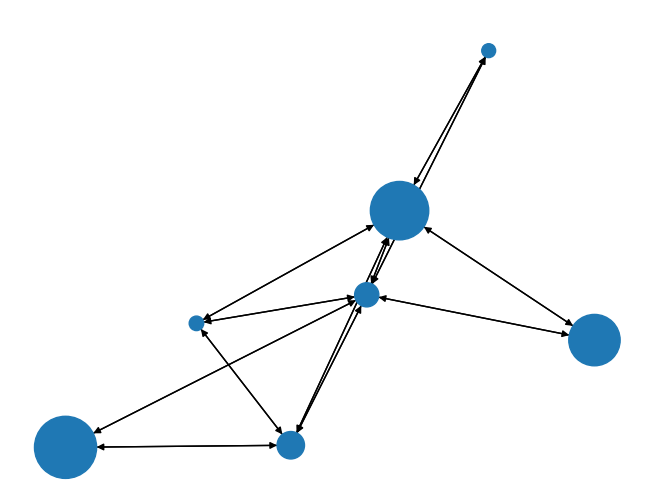

In [4]:
G = sim(barabasi_albert(n=7), activation_delay=1, activations=10000)
layout = draw(G)

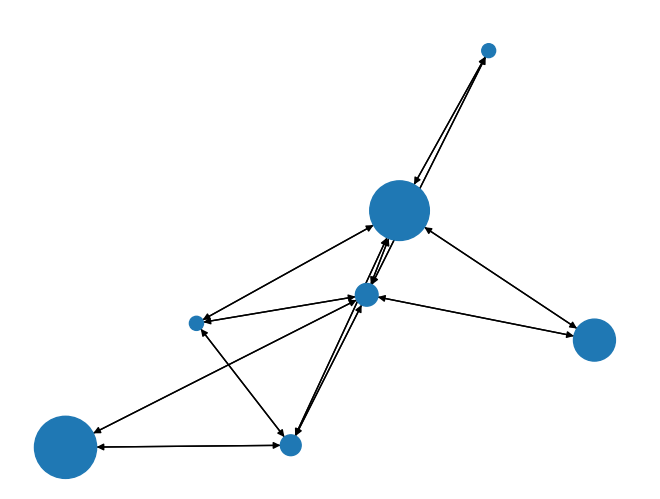

In [5]:
draw(G, size="reward", layout=layout)

In [6]:
runs = []
for i in range(10):
    net = barabasi_albert(n=7)
    cf = dict(G.nodes(data="compute_farness")).values()
    est_progagation_delay = sum(cf) / len(cf)
    for p in [
        "nakamoto",
        "ethereum-discount",
        "tailstorm-8-constant-heuristic",
        "tailstorm-8-discount-optimal",
    ]:
        G = sim(
            net,
            activation_delay=2 * est_progagation_delay,
            activations=1000,
            protocol=p,
            seed=i,
        )
        d = pd.DataFrame.from_dict(G.nodes, orient="index")
        d["protocol"] = p
        runs.append(d)
df = pd.concat(runs)
# calculate metrics
df["relative_reward"] = df.reward / np.sum(df.reward)
df["relative_activations"] = df.reward / np.sum(df.activations)
df["efficiency"] = df.reward / G.graph["head_progress"] / df.compute
df.efficiency.fillna(0, inplace=True)
display(df)

,activations,reward,compute_closeness,compute_farness,closeness,farness,compute,protocol,relative_reward,relative_activations,efficiency
0,7.0,4.000,0.413378,2.419091,0.423762,2.359816,0.006525,nakamoto,0.000120,0.000100,0.643919
1,250.0,203.000,0.421364,2.373244,0.329719,3.032884,0.237867,nakamoto,0.006088,0.005075,0.896449
2,113.0,60.000,0.345364,2.895493,0.320919,3.116051,0.107501,nakamoto,0.001799,0.001500,0.586273
3,112.0,77.000,0.391628,2.553441,0.369141,2.708994,0.119615,nakamoto,0.002309,0.001925,0.676190
4,217.0,105.000,0.274967,3.636805,0.241822,4.135280,0.214226,nakamoto,0.003149,0.002625,0.514849
...,...,...,...,...,...,...,...,...,...,...,...
2,27.0,19.625,0.513738,1.946516,0.432586,2.311681,0.024894,tailstorm-8-discount-optimal,0.000589,0.000491,0.828087
3,58.0,42.375,0.329124,3.038364,0.313899,3.185733,0.058601,tailstorm-8-discount-optimal,0.001271,0.001059,0.759572
4,78.0,50.875,0.270813,3.692582,0.261224,3.828135,0.076091,tailstorm-8-discount-optimal,0.001526,0.001272,0.702318
5,227.0,166.250,0.533417,1.874705,0.408433,2.448383,0.220113,tailstorm-8-discount-optimal,0.004986,0.004156,0.793377


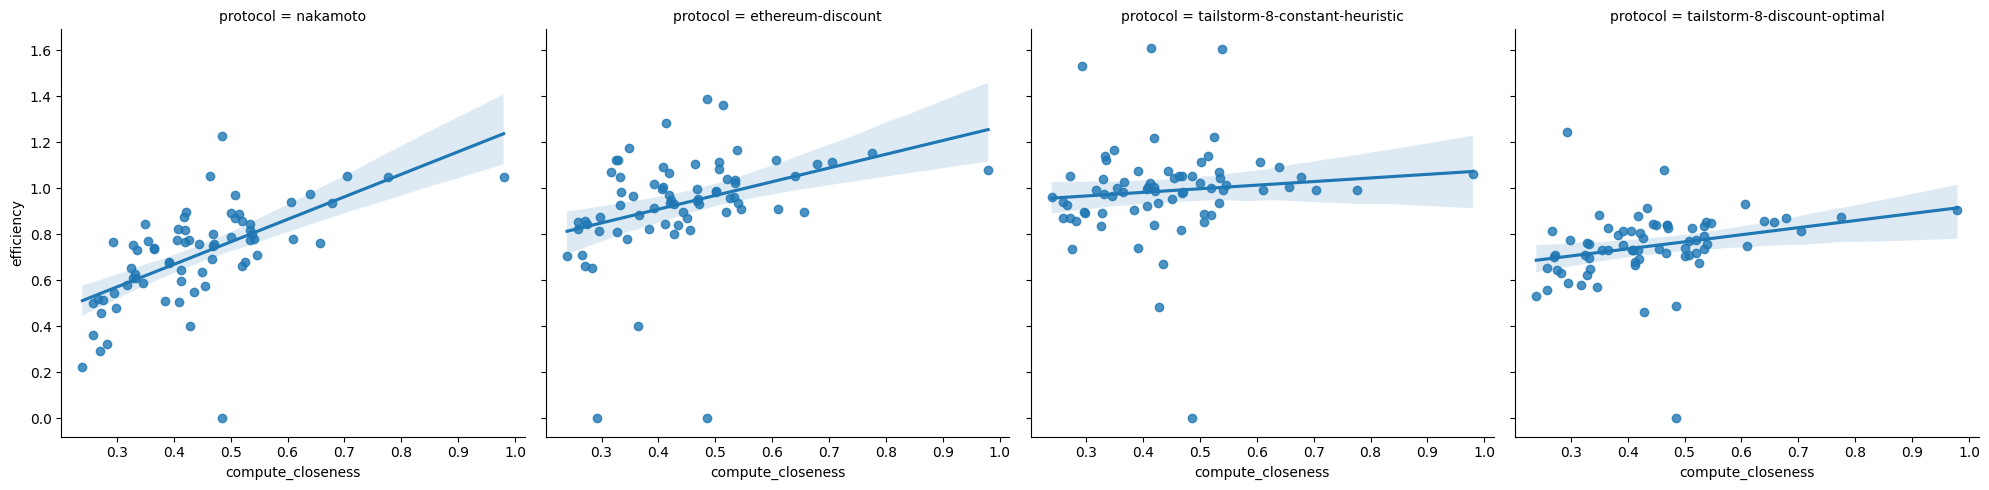

In [7]:
sns.lmplot(data=df, x="compute_closeness", y="efficiency", col="protocol")